# 2. Recognizing text in the images

We first define the libraries needed for this second stage.

In [1]:
import time
import easyocr
import cv2
import re 
import numpy as np
from IPython.display import clear_output, Image, display
from io import BytesIO
import PIL.Image
import fastwer
import json
import statistics as stats
import os
import warnings
warnings.filterwarnings('ignore')

We define the following function to ensure that we can plot the images without any problems from the _cv2_ library.

In [2]:
def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

For text location and recognition, we will be using _EasyOCR_. In comparison to _Tesseract_, this last one outperforms in terms of time processing, but I have been facing some issues with the _page segmentation mode_ used by _Tesseract_ and I haven't manage to set up a proper text recognition based in bounding box per lines. Despite the time consumption, _EasyOCR_ was easier to implement and it already provides the same format as the Ground Truth samples. In addition, _EasyOCR_ already implements its own image processing based on binarization and thresholding, among others. We set up the _EasyOCR_ reader as follows:

In [9]:
reader = easyocr.Reader(['en'], gpu = False)

Using CPU. Note: This module is much faster with a GPU.


Apart from  text location and recognition, we also track the time it takes to process the image to characterize the performance in terms of time consumption.

In [10]:
def process_image(image_name):
    start_time = time.time()
    result = reader.readtext(image_name)
    time_score = time.time() - start_time
    #print("--- %s seconds ---" % (time_score))
    return result, time_score

We use _regular expressions_ for recognizing the name of the shop and its address, the date of the purchase and the total amount. To do so, we make the following assumptions:
* The name of the shop is located either on the first line or the second line of the ticket. We compare the size of the two lines and we assume the name of the shop should stand out in the image.
* The address of the shop contains one of the following key words: _"NO."_ or _"Road"_.
* The date of the purchase is of the form: _00/00/0000_, _00-00-0000_, _00.00.0000_. We also look for the patterns _00[/ - .]0000000_ and _0000[/ - .]0000_, in case one of the symbols is not well recognized.
* The price is of the form _XX.XX_. We also asume that the higher value detected will correspond to the amount given by the buyer and that the second higher value is the actual price for the whole purchase.

In [18]:
def text_extraction(result, filename):
    
    img = cv2.imread(filename)

    date_pattern = '^(0[1-9]|[12][0-9]|3[01])[- /.](0[1-9]|1[012])[- /.](19|20)\d\d$'
    date_backup_pattern1 = '\d\d[- /.]\d\d\d\d\d\d\d'
    date_backup_pattern2 = '\d\d\d\d\d[- /.]\d\d\d\d'
    number_address_pattern = 'NO.'
    road_address_pattern = 'Road'
    price_pattern = '(\d+\.\d{1,2})'
    price_list = []
    final_price = 0.00
    date_backup = ''
    date = ''
    address = ''

    n_boxes = len(result)

    (x1a, y1a, x2a, y2a) = (result[0][0][0][0], result[0][0][0][1], result[0][0][2][0], result[0][0][2][1])
    (x1b, y1b, x2b, y2b) = (result[1][0][0][0], result[1][0][0][1], result[1][0][2][0], result[1][0][2][1])

    if (x2a - x1a > x2b - x1b):
        img = cv2.rectangle(img, (x1a, y1a), (x2a, y2a), (0, 255, 0), 2)
        shop = result[0][1]
    else:
        img = cv2.rectangle(img, (x1b, y1b), (x2b, y2b), (0, 255, 0), 2)
        shop = result[1][1]

    for i in range(n_boxes):
        if re.match(date_pattern, result[i][1]):
            (x1, y1, x2, y2) = (result[i][0][0][0], result[i][0][0][1], result[i][0][2][0], result[i][0][2][1])
            img = cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
            date = re.match(date_pattern, result[i][1]).group(0)
        if re.findall(date_backup_pattern1, result[i][1]):
            (x1, y1, x2, y2) = (result[i][0][0][0], result[i][0][0][1], result[i][0][2][0], result[i][0][2][1])
            img = cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
            try:
                date_backup = re.findall(date_backup_pattern1, result[i][1])[0]
            except:
                continue
        if re.findall(date_backup_pattern2, result[i][1]):
            (x1, y1, x2, y2) = (result[i][0][0][0], result[i][0][0][1], result[i][0][2][0], result[i][0][2][1])
            img = cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
            try:
                date_backup = re.findall(date_backup_pattern2, result[i][1])[0]
            except:
                continue
        if re.match(number_address_pattern, result[i][1], re.IGNORECASE):
            (x1, y1, x2, y2) = (result[i][0][0][0], result[i][0][0][1], result[i][0][2][0], result[i][0][2][1])
            img = cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
            address = result[i][1]
        if re.match(price_pattern, result[i][1]):
            (x1, y1, x2, y2) = (result[i][0][0][0], result[i][0][0][1], result[i][0][2][0], result[i][0][2][1])
            img = cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2) 
            price_list.append(result[i][1])
        if re.findall(road_address_pattern, result[i][1], re.IGNORECASE):
            (x1, y1, x2, y2) = (result[i][0][0][0], result[i][0][0][1], result[i][0][2][0], result[i][0][2][1])
            img = cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
            address = result[i][1]

    if date == '':
        date = date_backup

    try:
        price_list = [float(i) for i in price_list]
        price_list = set(price_list)

        if len(price_list) >= 2:
            price_list.remove(max(price_list))

        if len(price_list) != 0:
            final_price = max(price_list)

    except:
        final_price = 0.00
        
    return shop, date, address, final_price, img

We extract the information from the ticket and we format it for a nicer output:

In [12]:
def generate_sentences(shop, address, date, final_price):
    shop_sentence = "The shop's name is: {}".format(shop)
    date_sentence = "The date of the purchase is: {}".format(date)
    address_sentence = "The shop's address is: {}".format(address)
    price_sentence = "The final price of the purchase is: {:.2f} euros".format(final_price)

    full_text = shop_sentence + '\n' + address_sentence + '\n' + date_sentence + '\n' + price_sentence
    
    return full_text

We also characterize the performance by computing the CER and WER scores:

In [13]:
def evaluation_CER(shop, date, address, final_price, data):
    shop_CER = 1 - fastwer.score_sent(shop, data["company"], char_level=True)/100
    date_CER = 1 - fastwer.score_sent(date, data["date"], char_level=True)/100
    address_CER = 1 - fastwer.score_sent(address, data["address"], char_level=True)/100
    price_CER = 1 - fastwer.score_sent(str(final_price), data["total"], char_level=True)/100
    
    return stats.fmean([shop_CER, date_CER, address_CER, price_CER])

In [14]:
def evaluation_WER(shop, date, address, final_price, data):
    shop_WER = 1 - fastwer.score_sent(shop, data["company"])/100
    date_WER = 1 - fastwer.score_sent(date, data["date"])/100
    address_WER = 1 - fastwer.score_sent(address, data["address"])/100
    price_WER = 1 - fastwer.score_sent(str(final_price), data["total"])/100
    
    return stats.fmean([shop_WER, date_WER, address_WER, price_WER])

With the functions presented above, we can run some individual trials:

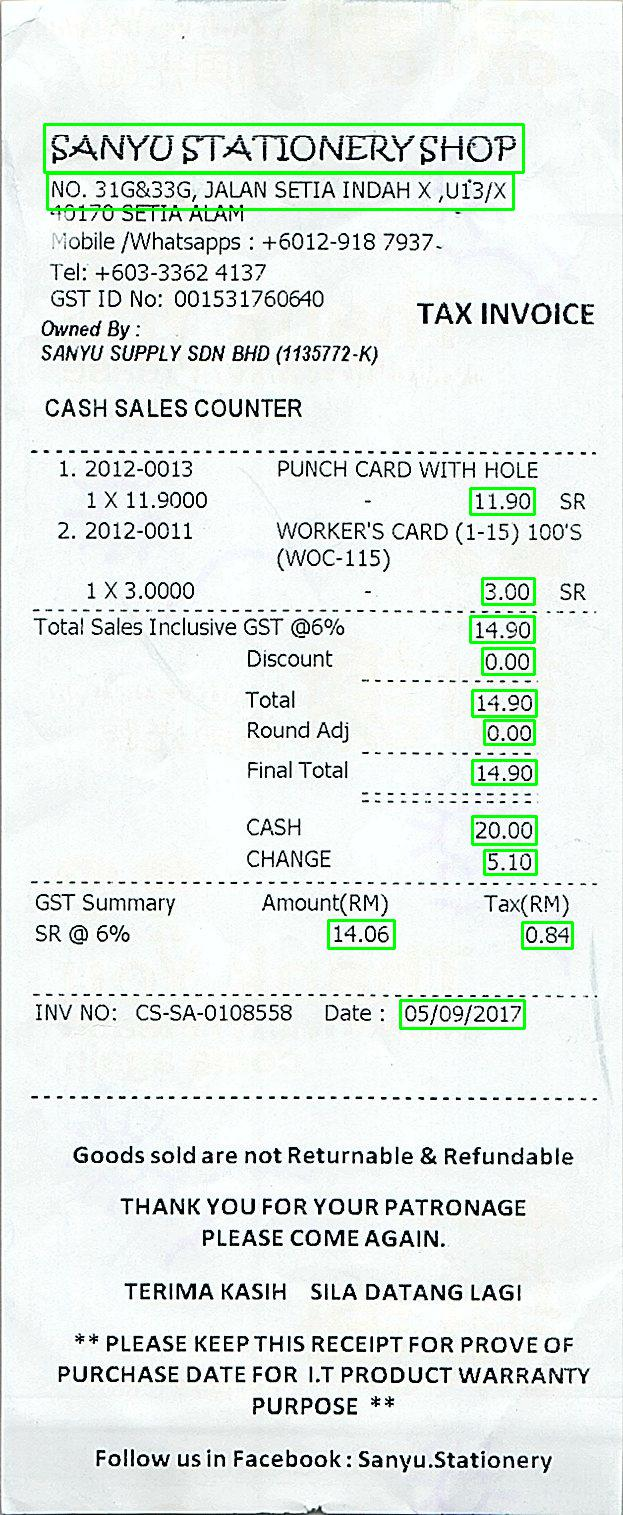

 --- Detected text ---
The shop's name is: SANYU STATIONERY SHOP
The shop's address is: NO. 31G8336, JALAN SETIA INDAH X ,U13/X
The date of the purchase is: 05/09/2017
The final price of the purchase is: 14.90 euros
 --- Ground truth text ---
The shop's name is: SANYU STATIONERY SHOP
The shop's address is: NO. 31G&33G, JALAN SETIA INDAH X ,U13/X 40170 SETIA ALAM
The date of the purchase is: 05/09/2017
The final price of the purchase is: 14.90 euros
 --- Scores ---
The mean time needed to process an image is of 20.03740906715393 seconds.
The CER score is of 0.8651785000000001.
The WER score is of 0.65.


In [15]:
directory = '/Users/aandvalenzuela/Downloads/HPDatabase/Tickets/imges/test'
filename = '470.jpg'

result, time_score = process_image(os.path.join(directory, filename))
shop, date, address, final_price, img = text_extraction(result, filename)

showarray(img)

detected_text = generate_sentences(shop, address, date, final_price)

print(" --- Detected text ---")
print(detected_text)

key_path = '/Users/aandvalenzuela/Downloads/HPDatabase/Tickets/key'
keyname = filename.replace(".jpg",".json");

f = open(os.path.join(key_path, keyname))
data = json.load(f)

gt_text = generate_sentences(str(data["company"]), str(data["address"]), str(data["date"]), float(data["total"]))
print(" --- Ground truth text ---")
print(gt_text)

CER_score = evaluation_CER(shop, date, address, final_price, data)
WER_score = evaluation_WER(shop, date, address, final_price, data)
print(" --- Scores ---")
print("The mean time needed to process an image is of {} seconds.".format(time_score))
print("The CER score is of {}.".format(CER_score))
print("The WER score is of {}.".format(WER_score))

We run the implementation over the whole database to fully characterize the performance. The results are not that promising probably due to the fact that the initial assumptions are too strong and that I am also not considering that the target information could be splitted in two lines (For example, in the image above, the address of the shop is splitted into two different lines).

In [19]:
import os
directory = '/Users/aandvalenzuela/Downloads/HPDatabase/Tickets/imges/test'
time_list = []
CER_list = []
WER_list = []

reader = easyocr.Reader(['en'], gpu = False)

for filename in os.listdir(directory):
    
    result, time_score = process_image(os.path.join(directory, filename))
    shop, date, address, final_price, img = text_extraction(result, filename)
    
    time_list.append(time_score)
    
    key_path = '/Users/aandvalenzuela/Downloads/HPDatabase/Tickets/key'
    keyname = filename.replace(".jpg",".json");
    
    f = open(os.path.join(key_path, keyname))
    data = json.load(f)
        
    CER_score = evaluation_CER(shop, date, address, final_price, data)
    CER_list.append(CER_score)
    WER_score = evaluation_WER(shop, date, address, final_price, data)
    WER_list.append(WER_score)

time_score = stats.fmean(time_list)
print("The mean time needed to process an image is of {} seconds.".format(time_score))
CER_score = stats.fmean(CER_list)
print("The CER score is of {}.".format(CER_score))
WER_score = stats.fmean(WER_list)
print("The WER score is of {}.".format(WER_score))

Using CPU. Note: This module is much faster with a GPU.


KeyboardInterrupt: 

The implementation has not been evaluated in terms of _Mean Average Precision_, but I guess it is not that important since the other scores are far from meeting the requirements (Lo importante es participar :) ).

I also gave a try with _Tesseract_ and text extraction was faster and more accurated, but it was difficult to deal with bounding boxes due to the aforementioned problem with the _page segmentation mode_.

In [21]:
import pytesseract
from pytesseract import Output

As far as I have seen with _Tesseract_, the time needed to process an image is of less than a second ( $\sim$ 0.8 seconds) that really outperforms the performance of _EasyOCR_, but it is still far from the requierements. To improve the speed of _Tesseract_ I have found that disabling the dictionaries it uses should increase recognition since most of the text isn’t dictionary words. Those falgs can be disabled by setting both of the configuration variables `load_system_daw` and `load_freq_daw` to _false_. Nevertheless, you can only set those flags from the _C++_ interface (I'd think, since there is no _python_ implementation of a `set_variable()` approach). Finally, I have also found a "fast" implementation of _Tesseract_ that should probably be considered at: https://github.com/tesseract-ocr/tessdata_fast

I have included a sample trial with Tesseract, but just for text extraction:

--- 1.0620198249816895 seconds ---


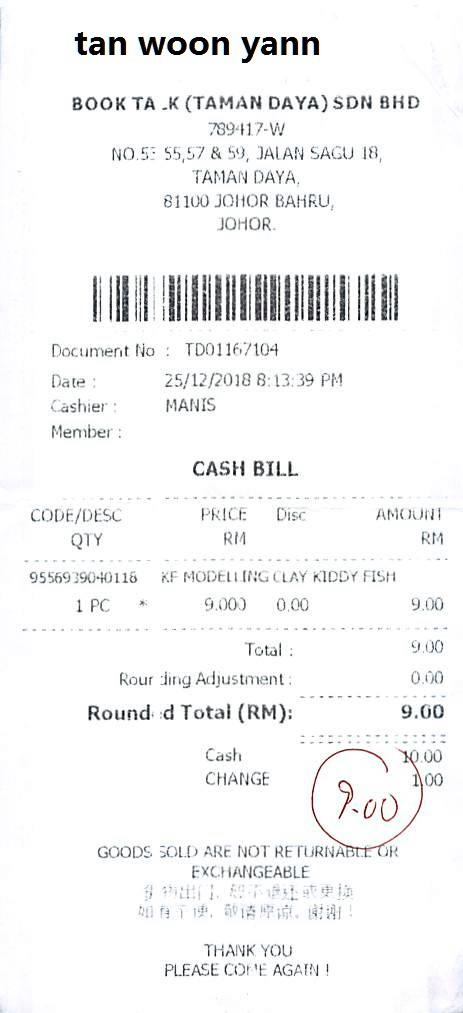

 --- Detected text ---




 tan woon yann
 BOOK TA -K (TAMAN DAYA) SDN BHD
 7B 7-W
 NO.5? 55,57 & 59, JALAN SAGU 18,
 TAMAN DAYA,
 81100 JOHOR BAHRU,
 JOHOR.
 Han |
 WAM MICA A
 Document Ho : TDO1167104
 Date 25/12/2018 8:13:39 PH
 Cashier MANIS
 Member
 CASH BILL
 CODE/DESC : PRICE Dise AMOUHT
 Qiy RIM RM
 955693040116 KF MODELLING cay KIDDY FISH :
 1 PC * 9.00) 0,00 9.00
 Total : 9.00
 Rour ding Adjustment 0.00
 Round: :d Total (RM): 9.60
 Cash oy 40.00
 CHANGE 00
 00
 GOODS SOLD ARE NOT RETURNAP aK
 EXCHANGEABLE
 an eT, SORA TH
 THANK YOU.


In [26]:
img = cv2.imread('000.jpg')

config = ("-l eng --oem 1 --psm 6")
pytesseract.pytesseract.tesseract_cmd = '/usr/local/bin/tesseract'
start_time = time.time()
d = pytesseract.image_to_data(img, config=config, output_type='data.frame')
print("--- %s seconds ---" % (time.time() - start_time))

showarray(img)

text = []
line = ""

print(" --- Detected text ---")
for index, row in d.iterrows():
    if row['word_num'] != 0:
        line = str(line) + " " + str(row['text'])
    else:
        text.append(line)
        print(line)
        line = ""

In [27]:
final_str = ""

with open('000.csv', newline="") as file:
    for line in file:
        text = line.split(",")[-1]
        final_str += str(text)

print(" --- Ground truth text ---")
print(final_str)

 --- Ground truth text ---
TAN WOON YANN
BOOK TA .K(TAMAN DAYA) SDN BND
789417-W



JOHOR.
DOCUMENT NO : TD01167104
DATE:
25/12/2018 8:13:39 PM
CASHIER:
MANIS
MEMBER:
CASH BILL
CODE/DESC
PRICE
DISC
AMOUNT
QTY
RM
RM
9556939040116
KF MODELLING CLAY KIDDY FISH
1 PC
*
9.000
0.00
9.00
TOTAL:
ROUR DING ADJUSTMENT:
0.00
ROUND D TOTAL (RM):
9.00
CASH
10.00
CHANGE
1.00
GOODS SOLD ARE NOT RETURNABLE OR
EXCHANGEABLE
***
***
THANK YOU
PLEASE COME AGAIN !
9.00



# 3. Reading out loud through text to speech

For the last part we will be using _gTTS_ (Google Text-to-Speech) to make use of Google Translate's text-to-speech API for converting text to speech.

In [28]:
from gtts import gTTS 
from IPython.display import Audio 

We make use of the pre-defined senteces of `generate_sentences()` to make some sort of manual summarization and we store the speech into an _.mp3_ file.

In [30]:
tts = gTTS(detected_text) 
tts.save('detected_text.mp3')

Finally, we reproduce the speech out loud:

In [31]:
sound_file = 'detected_text.mp3'
Audio(sound_file, autoplay=True) 